## Pre Modeling XAI Techniques Application
Additionally to the EDA already done, implementing Pre Modeling XAI techniques help us have a better understanding of the data itself, and in this notebook we will explore a few of them

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import f_classif

data = pd.read_csv('wnba_clean.csv')

In [43]:
data.head(1)

,shot_type,made_shot,shot_value,coordinate_x,coordinate_y,home_score,away_score,qtr,quarter_seconds_remaining,game_seconds_remaining,shot_group,distance,shot_group_encoded,shot_type_encoded
0,Jump Shot,False,0,-13,9,0,0,1,571,2371,Jump Shot,15.811388,3,29


In [44]:
categorical_features=['shot_type', 'shot_group']

In [45]:
data_filtered = data.drop(columns=categorical_features)

In [46]:
data_filtered.columns

Index(['made_shot', 'shot_value', 'coordinate_x', 'coordinate_y', 'home_score',
       'away_score', 'qtr', 'quarter_seconds_remaining',
       'game_seconds_remaining', 'distance', 'shot_group_encoded',
       'shot_type_encoded'],
      dtype='object')

### Correlation Heatmap to better understand relations between features

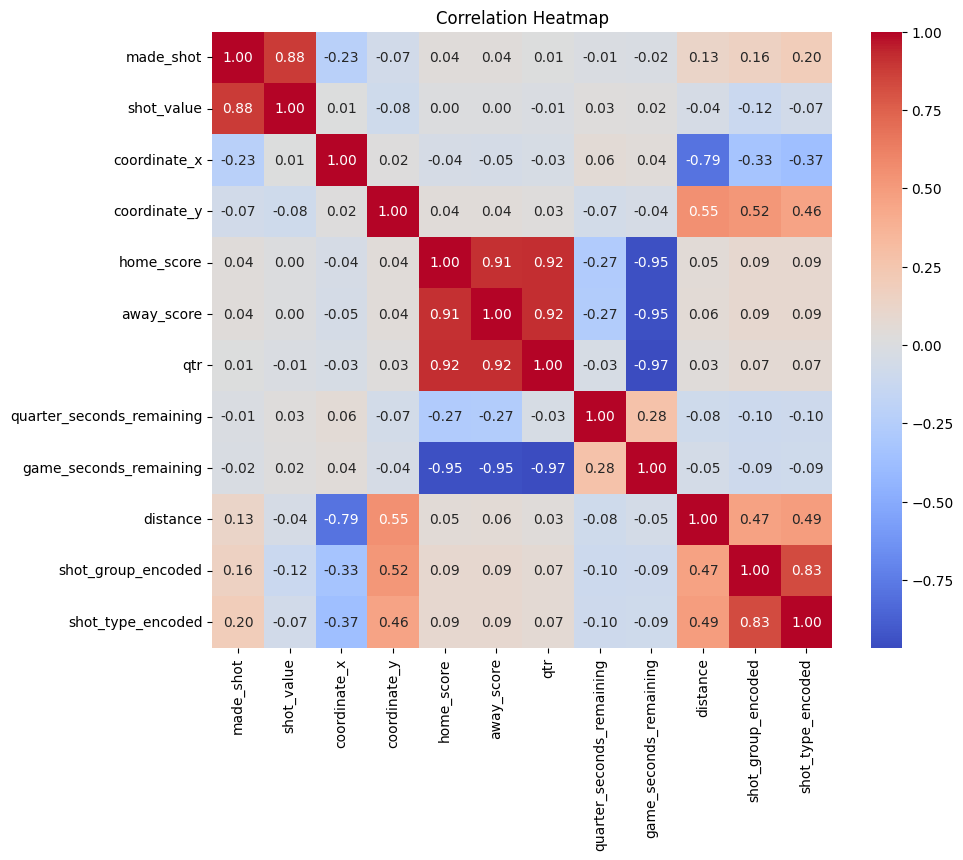


Correlation with Target:
 made_shot                    1.000000
shot_value                   0.882501
shot_type_encoded            0.195652
shot_group_encoded           0.158857
distance                     0.127237
away_score                   0.038233
home_score                   0.036446
qtr                          0.013127
quarter_seconds_remaining   -0.012926
game_seconds_remaining      -0.016165
coordinate_y                -0.074838
coordinate_x                -0.227411
Name: made_shot, dtype: float64


In [47]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = data_filtered.corr()  # For numerical features only
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Highlight correlations with the target variable
target_corr = correlation_matrix['made_shot'].sort_values(ascending=False)
print("\nCorrelation with Target:\n", target_corr)


Main insights: -Shot value has a huge correlation with the label, and that is obvious because of the nature of the two features, as the shot value represents the points the team got from that shot.

-Distance shows a moderate negative correlation with both made_shot (-0.13) and coordinate_x (-0.79), meaning longer distances and horizontal positioning reduce the likelihood of a made shot.

-Coordinate_y correlates positively with both distance (0.55) and shot_type_encoded (0.46), reflecting the spatial and categorical relationship of shot types.

-Strong correlations like game_seconds_remaining and quarter_seconds_remaining with qtr (quarter) highlight expected time dependencies.
Amongst other less relevant but present correlations

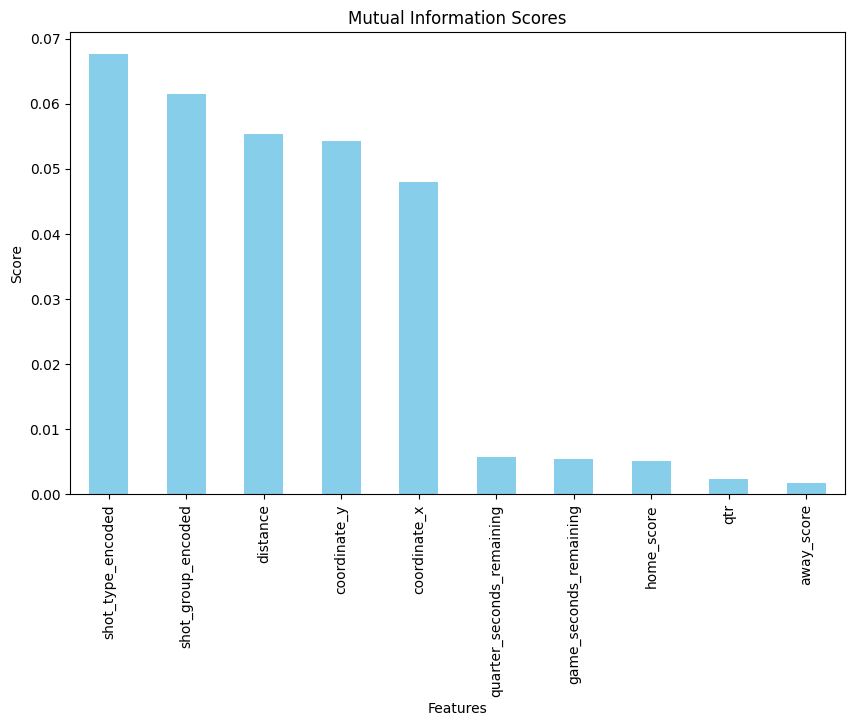


Top Features by Mutual Information:
 shot_type_encoded     0.067612
shot_group_encoded    0.061466
distance              0.055343
coordinate_y          0.054306
coordinate_x          0.047949
dtype: float64


In [56]:
# Mutual Information for Classification
X = data_filtered.drop(columns=['made_shot', 'shot_value'])  # Features
y = data_filtered['made_shot']  # Target variable

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Plot Mutual Information Scores
plt.figure(figsize=(10, 6))
mi_scores.plot(kind='bar', color='skyblue')
plt.title("Mutual Information Scores")
plt.xlabel("Features")
plt.ylabel("Score")
plt.show()

print("\nTop Features by Mutual Information:\n", mi_scores.head())


This Mutual Information Scores plot highlights the most relevant features for predicting the target variable:

shot_type_encoded and shot_group_encoded are the top contributors, indicating that shot classification plays a critical role in the prediction.
distance and coordinate_y are also significant, reinforcing their spatial influence on the outcome.
Low scores for features like quarter_seconds_remaining, home_score, and away_score suggest limited predictive power, that is exaclty why these were left out of the feature set for training in some models that can't capture complex relations (glass-box)

We removed shot_value due to its obvious and direct relationship with the target variable, ensuring the analysis focuses on features providing independent and meaningful insights.

In [49]:
# Normalize the dataset for statistical tests
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ANOVA F-Test
f_values, p_values = f_classif(X_scaled, y)
f_test_results = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'P-Value': p_values})
f_test_results = f_test_results.sort_values(by='F-Value', ascending=False)

print("\nANOVA F-Test Results:\n")
f_test_results


ANOVA F-Test Results:



,Feature,F-Value,P-Value
0,coordinate_x,2262.978199,0.000000e+00
9,shot_type_encoded,1651.642116,0.000000e+00
8,shot_group_encoded,1074.263647,1.220740e-232
7,distance,682.824724,2.635919e-149
1,coordinate_y,233.711992,1.286615e-52
3,away_score,60.743381,6.652983e-15
2,home_score,55.190712,1.114820e-13
6,game_seconds_remaining,10.845110,9.913982e-04
4,qtr,7.151539,7.492902e-03
5,quarter_seconds_remaining,6.934326,8.458826e-03


This ANOVA F-Test Results table ranks features based on their statistical significance and contribution to explaining the variance in the target variable:

coordinate_x has the highest F-value, indicating it is the most significant feature for prediction.
shot_type_encoded and shot_group_encoded follow closely, confirming their importance, as seen earlier in the Mutual Information analysis.
distance and coordinate_y also show substantial significance, aligning with their spatial relationships in prior analyses.
Features like quarter_seconds_remaining and qtr have lower F-values, indicating a comparatively minor contribution.

All features listed have extremely low P-values (close to 0), confirming their statistical significance in the model.

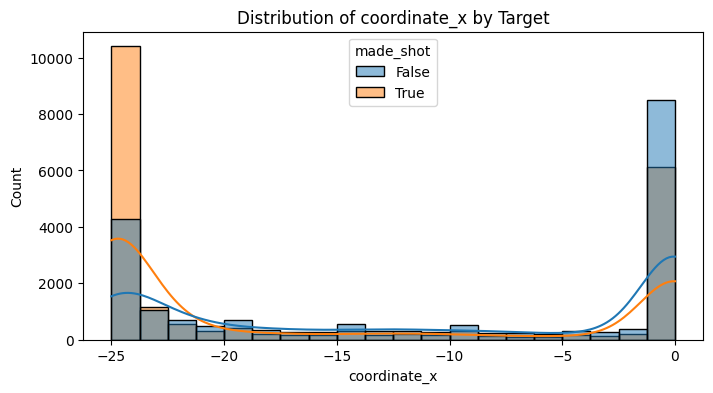

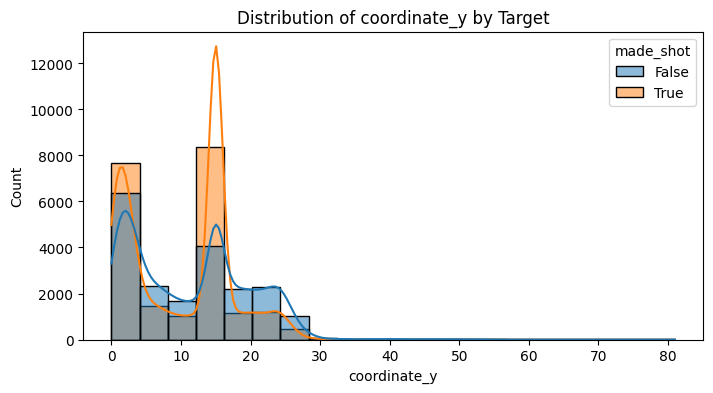

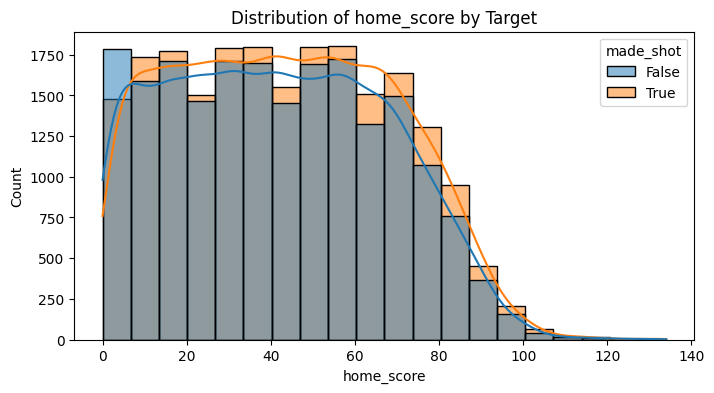

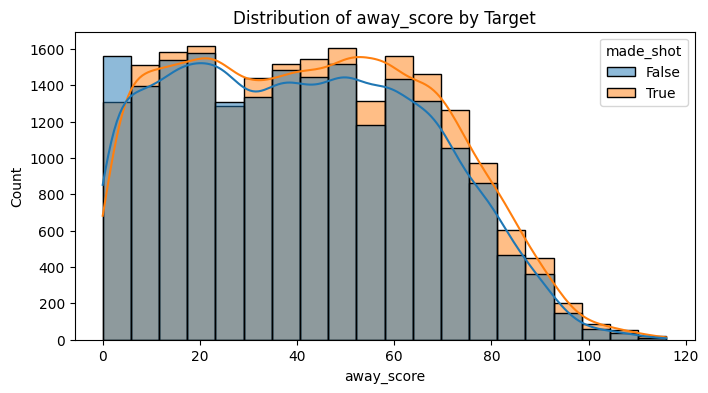

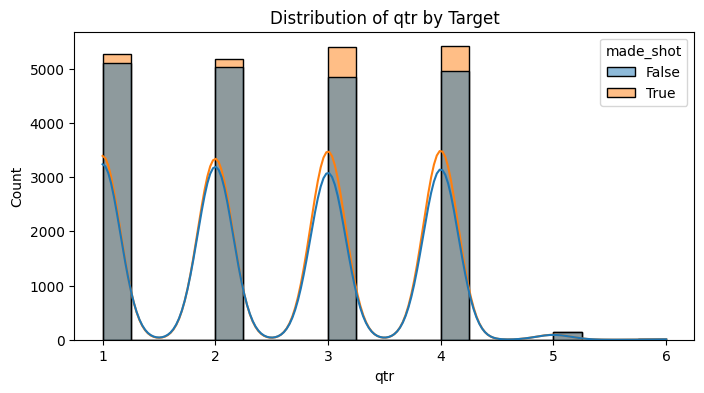

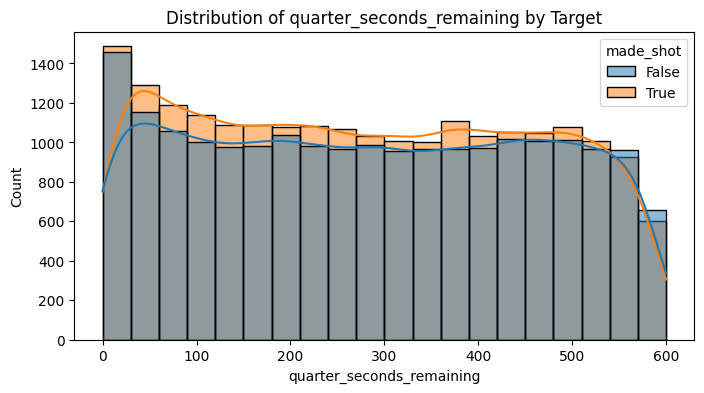

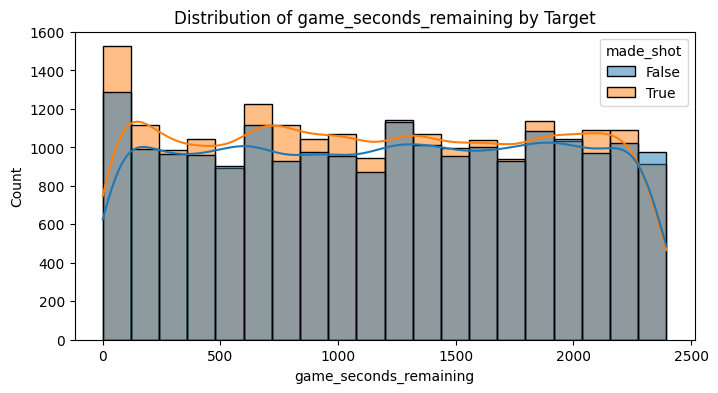

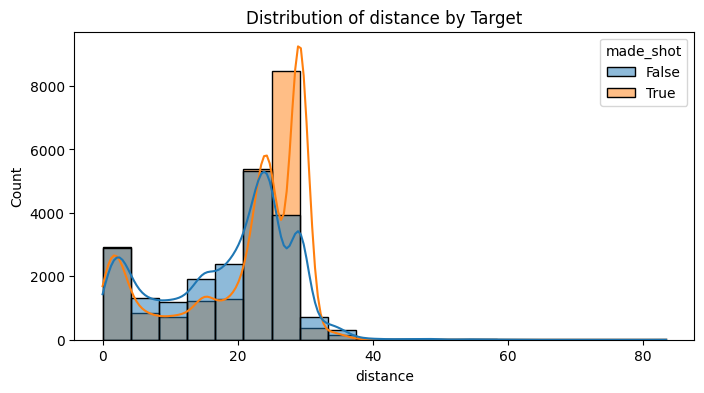

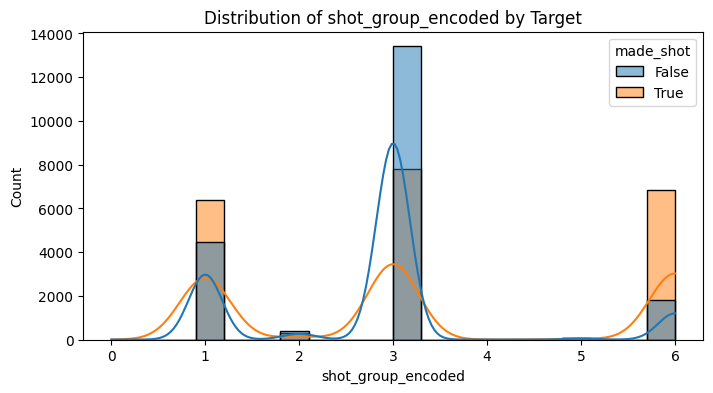

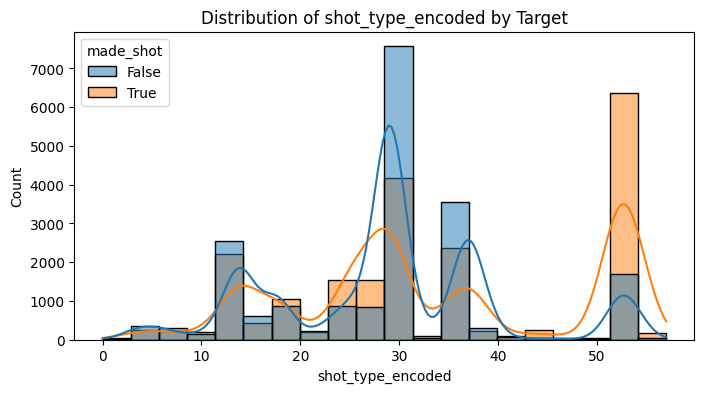

In [50]:
# Distribution of Features by Target
for column in X.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=data, x=column, hue='made_shot', kde=True, bins=20)
    plt.title(f"Distribution of {column} by Target")
    plt.show()


These plots were drawn to seethe distribution of made shots and missed shots accross features. This helps see some values that may influence a lot the outcome of the shot.

### Dimensionality Reduction
These methods were applied mainly to visualize the dataset structure and percept if there are clear separation of positive and negative clusters 

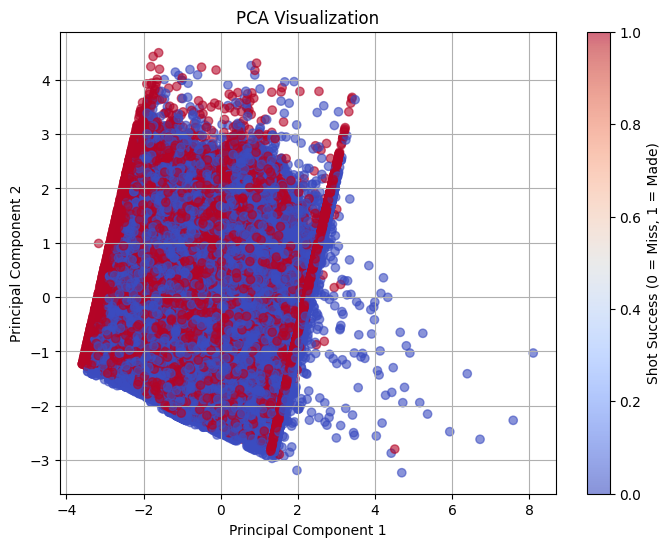

In [51]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Features to use for PCA
features = ['distance', 'shot_value', 'coordinate_x', 'coordinate_y', 
            'shot_group_encoded', 'home_score', 'away_score']

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_result = pca.fit_transform(scaled_features)

# Create a PCA dataframe
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['target'] = data['made_shot']  # Include target variable for visualization

# Plot the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['target'], cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Shot Success (0 = Miss, 1 = Made)')
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

This visualization highlights the challenge of clear separability but validates the potential influence of spatial and categorical features identified earlier.

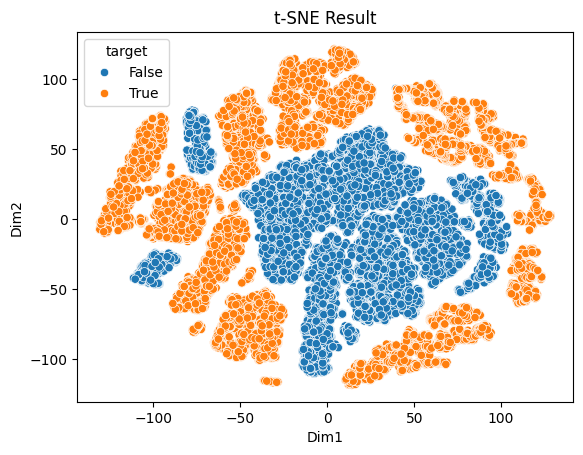

In [52]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(scaled_features)

# Visualize the t-SNE result
tsne_df = pd.DataFrame(data=tsne_data, columns=['Dim1', 'Dim2'])
tsne_df['target'] = data['made_shot']

sns.scatterplot(x='Dim1', y='Dim2', hue='target', data=tsne_df)
plt.title('t-SNE Result')
plt.show()


While PCA highlights global trends and feature importance for variance, t-SNE reveals local clusters and clear separability, making it more suitable for understanding complex relationships in this dataset.